In [11]:
import os
from particles import *
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.ndimage as ndimage

from matplotlib import rc

font = {"family": "serif", "weight": "normal", "size": 12}
rc("font", **font)
rc("text", usetex=True)

In [ ]:
#Manually input the parameters of the simulation
circulation = 2000
radius = 5000
lmbda = 100
Tc = 4*1.25643*(pi*radius)**2/((1-exp(-1.25643))*circulation)

domain_size = radius*40 #meters
rTrigger = domain_size/2

name_files = ["tracer","inertial_t100","inertial_t1000","inertial_t10000","inertial_t100000","inertial_t1000000"]
names = ["$t_0 = 100$","$t_0 = 1000$","$t_0 = 10000$","$t_0 = 100000$","$t_0 = 1000000$"]

paths = []

for file in name_files:
    paths.append(Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\\Work\\Simulation\\Analytical simulation\\"+str(circulation)+"_"+str(radius)+"_"+str(lmbda)+"\\"+str(file)))


timestep = Tc/300 #seconds

StokesN = [0,100/Tc,1000/Tc,10000/Tc,100000/Tc,1000000/Tc]

### Detect discontinuities and unravel periodicity

In [13]:
def unravel(particles_traj) :
    traj_px = []
    traj_py = []
    for i in range(len(particles_traj)):
        Nx = 0
        Ny = 0
        traj_px.append([particles_traj[i].px[0]])
        traj_py.append([particles_traj[i].py[0]])
        for j in range(1,len(particles_traj[i].px)):
            if particles_traj[i].px[j] - particles_traj[i].px[j-1] > rTrigger:
                Nx -= 1
            if particles_traj[i].px[j] - particles_traj[i].px[j-1] < -rTrigger:
                Nx += 1
            if particles_traj[i].py[j] - particles_traj[i].py[j-1] < -rTrigger:
                Ny += 1
            if particles_traj[i].py[j] - particles_traj[i].py[j-1] > rTrigger:
                Ny -= 1
            traj_px[-1].append(particles_traj[i].px[j]+Nx*2*rTrigger)
            traj_py[-1].append(particles_traj[i].py[j]+Ny*2*rTrigger)
    return traj_px, traj_py

In [14]:
def diff_computation(n):
    particles_traj = ReadParticles(os.path.basename(os.path.normpath(paths[0])), paths[0])
    traj_px_tracer, traj_py_tracer = unravel(particles_traj)

    particles_traj = ReadParticles(os.path.basename(os.path.normpath(paths[n+1])), paths[n+1])
    traj_px_inertial, traj_py_inertial = unravel(particles_traj)

    diff_px = []
    diff_py = []

    for i in range(len(traj_px_inertial)) :
        diff_px.append(traj_px_inertial[i][-1] - traj_px_tracer[i][-1])
        diff_py.append(traj_py_inertial[i][-1] - traj_py_tracer[i][-1])

    diff = (np.array(diff_py)**2+np.array(diff_px)**2)**0.5

    return diff


### Plot the distribution of the distance between the particles final positions and the corresponding passive particle position

C:\Users\albou\AppData\Local\Temp\ipykernel_15956\924798779.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1e6)


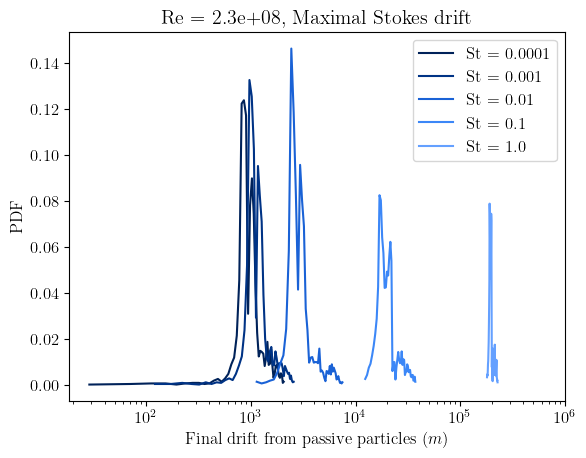

In [15]:
max = 0
colors = [(0,34/255,89/255),(0,51/255,133/255),(26/255,98/255,214/255),(60/255,135/255,247/255),(100/255,160/255,1)]
for i in range(len(names)) :
    diff = diff_computation(i)
    if np.max(diff) :
        max = np.max(diff)
    hist = ndimage.histogram(diff, min=np.min(diff), max = np.max(diff), bins=50)
    plt.plot(np.linspace(np.min(diff), np.max(diff), num = 50),hist/np.sum(hist) ,label = "St = "+ str(round(StokesN[i+1],4-i)),c = colors[i])
plt.xscale('log')
plt.xlabel("Final drift from passive particles ($m$)")
plt.ylabel("PDF")
plt.xlim(0,1e6)
plt.title("Re = "+str("{:.1e}".format(round(circulation*(1-exp(-1.25643))/(2*3.14159*1e-6))))+", Maximal Stokes drift")
plt.legend()
plt.savefig("drift_"+str(radius)+".pdf")
# plt.hist((np.array(diff_py)**2+np.array(diff_px)**2)**0.5,bins= 50, density=True)